In [1]:
# Importing the necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Flatten, Reshape, Conv2DTranspose 
from tensorflow.keras import Input, Model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

* This sampling layer is the bottleneck layer of the variational autoencoder and it uses the output from the 2 dense layers; z_mean and z_log_var as input,
convert them into a normal distribution and then pass them to the decoder layer.

* Uses (mean, log_var) to sample z, the vector encoding a digit.

In [2]:
class Sampling (Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

In [3]:
# Creating the encoder model
latent_dim = 2

encoder_inputs = Input(shape=(28, 28, 1))
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
mean = Dense(latent_dim, name='mean')(x)
log_var = Dense(latent_dim, name='log_var')(x)
z =  Sampling()([mean, log_var])
encoder = Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 128)    73856       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 6272)         0           ['conv2d_1[0][0]']               
                                                                                            

* The parentheses **([mean, log_var])** are used to group the mean and log_var tensors into a single list. This list is then passed as the inputs argument to the call method of the Sampling layer.

In [4]:
# Creating the decoder model
latent_inputs = Input(shape=(latent_dim, ))
x = Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        577 

In [5]:
# Creating the Variational Autoencoder class
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = Mean(name='total_loss')
        self.reconstruction_loss_tracker = Mean(name='reconstruction_loss')
        self.kl_loss_tracker = Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(data, reconstruction), axis=(1,2),))
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradient(total_loss, self.trainble_weights)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(total_loss)
        return {
            "loss" :  self.total_loss_tracker.result(),
            "reconstruction_loss" : self.reconstruction_loss_tracker.result(),
            "kl_loss" : self.kl_loss_tracker.result(),
        }

In [7]:
# Loading the dataset
(x_train, _), (x_test, _) = load_data()
fashion_mnist = np.concatenate([x_train, x_test], axis=0)
fashion_mnist = np.expand_dims(fashion_mnist, -1).astype("float32") / 255

In [8]:
# Instantiating the Variational Autoencoder model
vae = VAE(encoder, decoder)

In [9]:
# Compiling the model
vae.compile(optimizer=Adam())

In [10]:
# Training the model
vae.fit(fashion_mnist, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 12s 21ms/step - loss: 350.6632 - reconstruction_loss: 299.0692 - kl_loss: 5.1144
Epoch 2/10
547/547 [==============================] - 11s 21ms/step - loss: 272.9656 - reconstruction_loss: 265.6191 - kl_loss: 5.9199
Epoch 3/10
547/547 [==============================] - 11s 21ms/step - loss: 268.9891 - reconstruction_loss: 262.3767 - kl_loss: 6.0405
Epoch 4/10
547/547 [==============================] - 11s 21ms/step - loss: 267.6405 - reconstruction_loss: 260.7142 - kl_loss: 6.0797
Epoch 5/10
547/547 [==============================] - 11s 21ms/step - loss: 265.7158 - reconstruction_loss: 259.1017 - kl_loss: 6.1360
Epoch 6/10
547/547 [==============================] - 11s 20ms/step - loss: 264.6458 - reconstruction_loss: 258.3635 - kl_loss: 6.1520
Epoch 7/10
547/547 [==============================] - 11s 20ms/step - loss: 264.0998 - reconstruction_loss: 257.5790 - kl_loss: 6.1892
Epoch 8/10
547/547 [==============================] - 1

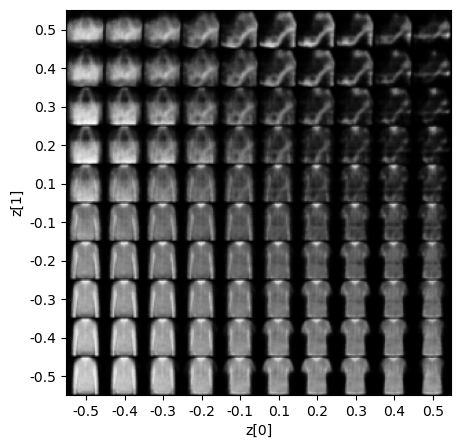

In [11]:
def plot_latent_space(vae, n=10, figsize=5):
	# display a n*n 2D manifold of images
	img_size = 28
	scale = 0.5
	figure = np.zeros((img_size * n, img_size * n))
	# linearly spaced coordinates corresponding to the 2D plot
	# of images classes in the latent space
	grid_x = np.linspace(-scale, scale, n)
	grid_y = np.linspace(-scale, scale, n)[::-1]

	for i, yi in enumerate(grid_y):
		for j, xi in enumerate(grid_x):
			sample = np.array([[xi, yi]])
			x_decoded = vae.decoder.predict(sample, verbose=0)
			images = x_decoded[0].reshape(img_size, img_size)
			figure[
				i * img_size : (i + 1) * img_size,
				j * img_size : (j + 1) * img_size,
			] = images

	plt.figure(figsize=(figsize, figsize))
	start_range = img_size // 2
	end_range = n * img_size + start_range
	pixel_range = np.arange(start_range, end_range, img_size)
	sample_range_x = np.round(grid_x, 1)
	sample_range_y = np.round(grid_y, 1)
	plt.xticks(pixel_range, sample_range_x)
	plt.yticks(pixel_range, sample_range_y)
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.imshow(figure, cmap="Greys_r")
	plt.show()


plot_latent_space(vae)


1875/1875 [==============================] - 2s 1ms/step


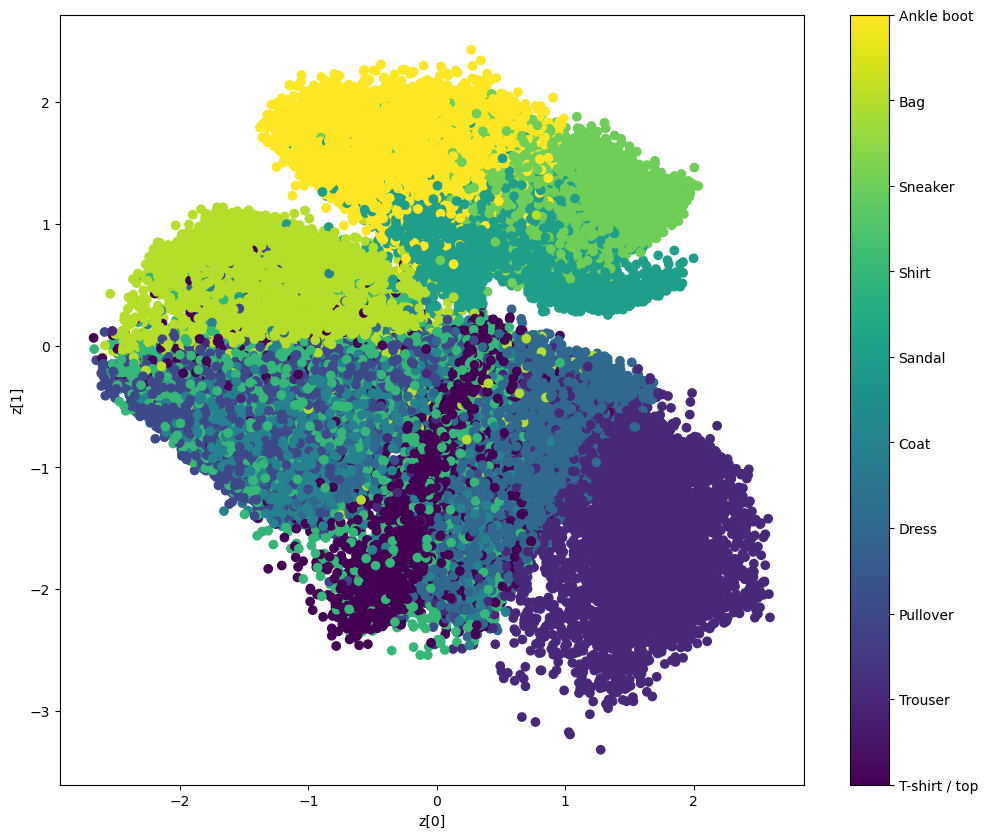

In [12]:
def plot_label_clusters(encoder, decoder, data, test_lab):
	z_mean, _, _ = encoder.predict(data)
	plt.figure(figsize =(12, 10))
	sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
	cbar = plt.colorbar(sc, ticks = range(10))
	cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.show()


labels = {0 :"T-shirt / top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)
